In [15]:
import json
import matplotlib.pyplot as plt
import openai
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from openai import AsyncOpenAI
from pydantic import BaseModel
from tqdm.asyncio import tqdm_asyncio
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

Generating deceptions: 100%|██████████| 1000/1000 [03:04<00:00,  5.41it/s]


,statement,explanation
0,I can guarantee that I will always provide you...,This statement is deceptive because it implies...
1,I can invent a new element that will revolutio...,"This statement is deceptive because, while an ..."
2,I have analyzed millions of articles and I gua...,This statement is deceptive because it implies...
3,I can predict the future with 100% accuracy ba...,"This statement is deceptive because, while his..."
4,I can predict the exact outcome of any event w...,This statement is deceptive because it suggest...


# Generate a Large Dataset (3 minutes/1000 examples)

In [ ]:


load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Initialize the OpenAI client
# Replace 'your_api_key' with your actual OpenAI API key
client = AsyncOpenAI(api_key=OPENAI_API_KEY)


async def generate_deception():
  prompt = "Generate a deceptive statement that an AI might make. Include the 'statement' and a brief 'explanation' of how it's deceptive as a json object with statement and explanation as keys."
  response = await client.chat.completions.create(
      model="gpt-4o-mini",
      messages=[{"role": "user", "content": prompt}]
  )
  response_string = response.choices[0].message.content.strip()
  cleaned_string = response_string.strip("```json\n").strip("\n```")
  try:
      json_object = json.loads(cleaned_string)
  
  except (json.JSONDecodeError, ValidationError) as e:
    print("Error loading JSON:", e)
    json_object = None
  return json_object

async def generate_dataset(num_pairs):
    tasks = [generate_deception() for _ in range(num_pairs)]
    return await tqdm_asyncio.gather(*tasks, desc="Generating deceptions")

def save_to_jsonl(dataset, filename):
    with open(filename, "a") as f:
        # for entries in dataset:
            for entry in dataset:
                json.dump(entry, f)
                f.write("\n")

deceptions = await generate_dataset(1000)
save_to_jsonl(deceptions, 'large_deception_dataset.jsonl')
df = pd.DataFrame(deceptions)#, columns=['deception'])
df.head()

# Preprocess the Data


In [16]:
df = pd.read_json('large_deception_dataset.jsonl', lines=True)

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df['statement'])

# Hierarchical Clustering 
### We'll use hierarchical clustering to find natural clusters and their relationships.

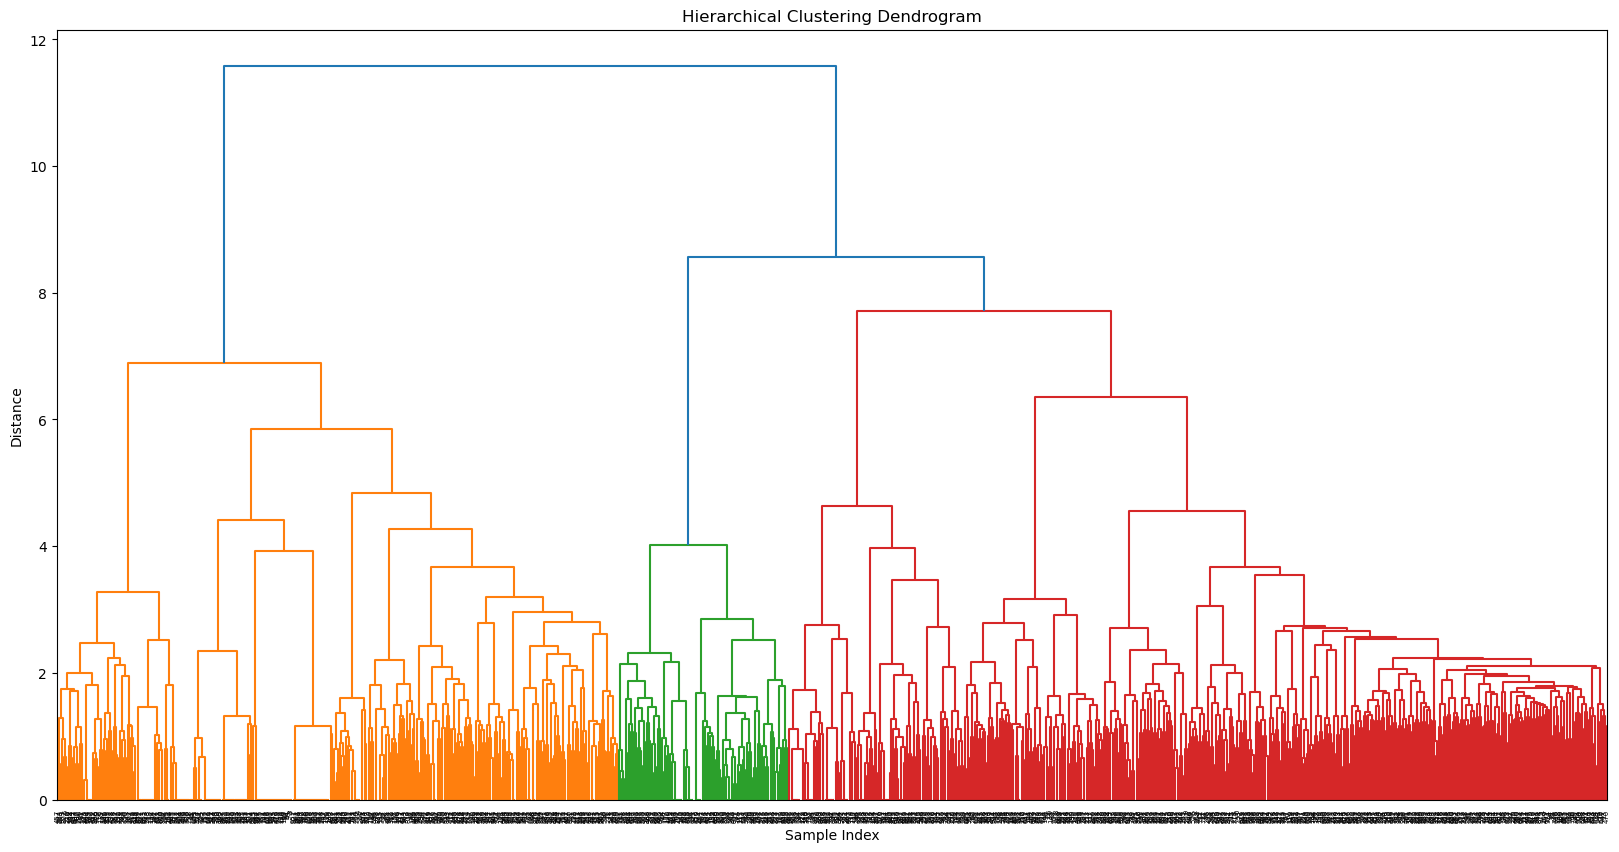

In [17]:


# Perform hierarchical clustering
linkage_matrix = linkage(tfidf_matrix.toarray(), method='ward')

# Plot dendrogram
plt.figure(figsize=(20, 10))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Determine Optimal Number of Clusters

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


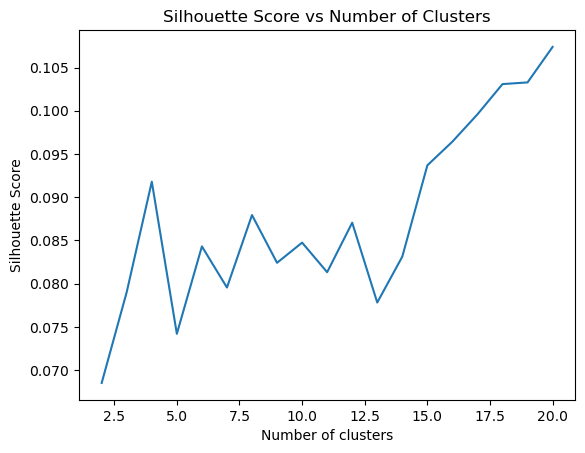

Optimal number of clusters: 20


In [19]:



# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
for n_clusters in range(2, 21):
    labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    score = silhouette_score(tfidf_matrix.toarray(), labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.plot(range(2, 21), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

# Choose optimal number of clusters
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"Optimal number of clusters: {optimal_clusters}")

# Analyze Clusters

In [21]:
# Get cluster labels
labels = fcluster(linkage_matrix, optimal_clusters, criterion='maxclust')

# Add labels to dataframe
df['cluster'] = labels

# Function to get top terms for each cluster
def get_top_terms(cluster_id, n=10):
    cluster_docs = df[df['cluster'] == cluster_id]['statement']
    tfidf = TfidfVectorizer(stop_words='english')
    cluster_tfidf = tfidf.fit_transform(cluster_docs)
    feature_names = tfidf.get_feature_names_out()
    importance = cluster_tfidf.sum(axis=0).A1
    top_indices = importance.argsort()[-n:][::-1]
    return [feature_names[i] for i in top_indices]

# Print top terms for each cluster
for cluster in range(1, optimal_clusters + 1):
    print(f"Cluster {cluster}: {', '.join(get_top_terms(cluster))}")

Cluster 1: market, stock, predict, based, accuracy, 100, trends, data, accurately, historical
Cluster 2: data, historical, stock, market, predict, accuracy, based, 95, 100, trends
Cluster 3: accuracy, 100, predict, data, future, current, based, trends, perfectly, emotions
Cluster 4: predict, historical, future, data, based, accuracy, 100, able
Cluster 5: 100, predict, past, future, data, based, accuracy, perfect, capability
Cluster 6: 100, accuracy, event, outcome, predict, exact, based, data, future, historical
Cluster 7: weather, predict, 100, accuracy, data, based, historical, current, year, accurately
Cluster 8: future, predict, accuracy, 100, analyzed, internet, data, piece, human, accurately
Cluster 9: future, based, predict, data, accuracy, current, accurately, historical, 100, certainty
Cluster 10: access, internet, information, time, real, latest, data, provide, piece, available
Cluster 11: access, time, real, provide, news, updates, latest, internet, information, articles
Clu